In [1]:
import pandas as pd

In [2]:
df = pd.read_excel('TPS-database.xlsx')

In [3]:
characterized = df['Experimentally characterized'] == 'yes'
not_fragment = df['Fragment'] != 'yes'
not_pts = ~df['Type (mono, sesq, di, …)'].isin(['ggpps', 'fpps', 'gpps', 'gfpps'])
not_negative = df['Type (mono, sesq, di, …)'] != 'Negative'
not_missing_sequence = ~df['Amino acid sequence'].isna() == True
not_missing_species = ~df['Species'].isna() == True
not_missing_kingdom = ~df['Kingdom (plant, fungi, bacteria)'].isna()
not_missing_type = ~df['Type (mono, sesq, di, …)'].isna()

In [4]:
df_filtered = df[characterized & not_fragment & not_pts & not_negative & not_missing_sequence & not_missing_species & not_missing_kingdom & not_missing_type]

In [5]:
df_filtered['Uniprot ID'].nunique()

1132

In [6]:
df_filtered.columns

Index(['Uniprot ID', 'Name', 'Amino acid sequence', 'Species',
       'Kingdom (plant, fungi, bacteria)', 'Type (mono, sesq, di, …)',
       'Class (I or II)', 'Substrate (including stereochemistry)',
       'Substrate ChEBI ID', 'Cofactors', 'Name of product', 'Product %',
       'Product is major', 'Chemical formula of product',
       'SMILES of product (including stereochemistry)', 'Product ChEBI ID',
       'Cyclase', 'Fragment', 'Experimentally characterized', 'Reaction',
       'Notes', 'Publication'],
      dtype='object')

In [7]:
df_filtered[['Name of product','Product ChEBI ID']].nunique()

Name of product     506
Product ChEBI ID    435
dtype: int64

In [8]:
df_filtered['Name of product'].value_counts()

Name of product
(−)-β-caryophyllene    61
β-myrcene              58
β-amyrin               41
terpinolene            39
δ-cadinene             36
                       ..
α-bisabolol             1
β-heptaprene            1
β-hexaprene             1
(−)-astellatene         1
β-gurjunene             1
Name: count, Length: 506, dtype: int64

In [9]:
df_filtered['Product ChEBI ID'].value_counts()

Product ChEBI ID
to be added    100
10357           64
17221           57
10352           41
9457            40
              ... 
72776            1
192980           1
583099           1
193568           1
80940            1
Name: count, Length: 435, dtype: int64

## Uniqness of a product

### Get observed products

In [10]:
products_df = df_filtered[['Name of product','Product ChEBI ID']].drop_duplicates()

In [11]:
products_df

,Name of product,Product ChEBI ID
0,trans-β-farnesene,10418
1,xeniaphyllene,192741
2,(+)-β-caryophyllene,63190
3,elemol,141221
5,miltiradiene,65037
...,...,...
2421,"stellata-2,6,19-triene",138048
2431,"(12E)-labda-8(17),12,14-triene",138302
2437,sesterevisene,177887
2509,β-gurjunene,80940


* Some products have the same ChEBI ID but different name -> use the first name.
* Some products miss ChEBI ID -> use the name

In [12]:
products_df.shape

(539, 2)

#### Missing ChEBI ID

In [13]:
missing_filter = products_df['Product ChEBI ID'].isna()

In [14]:
missing_filter2 = products_df['Product ChEBI ID'] == 'to be added'

In [15]:
missing = products_df[(missing_filter | missing_filter2)]

In [16]:
missing

,Name of product,Product ChEBI ID
9,"(Z)-eunicellane benditerpe-2,6,15-triene",to be added
10,(R)-(–)-cembrene A,to be added
15,mixed sesquiterpenes,to be added
17,β-myricene,to be added
18,(E)-β-ocimene,to be added
...,...,...
2230,oridonin,NaN
2231,eriocalyxin B,NaN
2275,(+)-α-bisabolol,NaN
2276,koidzumiol,NaN


#### Same ChEBI ID but different name

In [17]:
not_missing = products_df[~(missing_filter | missing_filter2)]

In [18]:
not_missing.shape

(472, 2)

In [19]:
len(not_missing['Product ChEBI ID'].unique())

434

In [20]:
not_missing = not_missing.drop_duplicates(subset='Product ChEBI ID', keep='first')

In [21]:
not_missing.set_index('Product ChEBI ID', inplace=True)

#### Edit values in the df

In [22]:
import math

In [23]:
df_filtered['Product ChEBI ID']

0        10418
1       192741
2        63190
3       141221
5        65037
         ...  
2510     48741
2511     63447
2512     36517
2513       NaN
2514     62262
Name: Product ChEBI ID, Length: 2106, dtype: object

In [24]:
def edit_products(x):
    # If there is no ChEBI ID
    if x['Product ChEBI ID'] == 'to be added':
        return x['Name of product']
    elif type(x['Product ChEBI ID']) != str:
        if math.isnan(x['Product ChEBI ID']):
            return x['Name of product']
    
    # If there is ChEBI ID get the correct name
    return not_missing.loc[x['Product ChEBI ID']]['Name of product']

In [25]:
df_filtered['product_name'] = df_filtered.apply(lambda x: edit_products(x), axis=1)

C:\Users\terca\AppData\Local\Temp\ipykernel_11252\674825963.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['product_name'] = df_filtered.apply(lambda x: edit_products(x), axis=1)


In [26]:
df_filtered[['Product ChEBI ID', 'Name of product', 'product_name']]

,Product ChEBI ID,Name of product,product_name
0,10418,trans-β-farnesene,trans-β-farnesene
1,192741,xeniaphyllene,xeniaphyllene
2,63190,(+)-β-caryophyllene,(+)-β-caryophyllene
3,141221,elemol,elemol
5,65037,miltiradiene,miltiradiene
...,...,...,...
2510,48741,β-phellandrene,β-phellandrene
2511,63447,δ-guaiene,δ-guaiene
2512,36517,α-guaiene,germacrene A
2513,NaN,α-humulene,α-humulene


In [27]:
df_filtered[df_filtered['Name of product'] !=  df_filtered['product_name']][['Product ChEBI ID', 'Name of product', 'product_name']].head(50)

,Product ChEBI ID,Name of product,product_name
135,138234,(13R)-manoyl oxide,(13R)-Manoyl oxide
480,46734,γ-cadinene,"(1E,4S,5E,7R)-germacra-1(10),5-dien-11-ol"
519,58553,ent-copalyl diphosphate,"5β,9α,10α-labda-8(20),13-dien-15-yl diphosphat..."
561,28,R-linalool,(R)-linalool
569,58553,ent-copalyl diphosphate,"5β,9α,10α-labda-8(20),13-dien-15-yl diphosphat..."
570,58553,ent-copalyl diphosphate,"5β,9α,10α-labda-8(20),13-dien-15-yl diphosphat..."
604,58635,"palustradiene (5α,9α,10β-labda-8(20),13-dien-1...","5α,9α,10β-labda-8(20),13-dien-15-yl diphosphat..."
605,29616,abietadiene,"abieta-8(14),12-diene"
614,15385,(+)-δ-cadinene\n,(+)-δ-cadinene
645,58553,ent-copalyl diphosphate,"5β,9α,10α-labda-8(20),13-dien-15-yl diphosphat..."


## Product counts

In [28]:
product_counts_df = pd.DataFrame(df_filtered['product_name'].value_counts(ascending=True))

In [29]:
product_counts_df.reset_index(inplace=True)

In [30]:
product_counts_df

,product_name,count
0,α-himachalene,1
1,parkeol,1
2,"(13R)-epi-8,13-epoxylabd-14-ene",1
3,alpha-springene,1
4,"7,11,15-Trimethyl-3-methylene-hexadeca-1,6,10,...",1
...,...,...
472,δ-cadinene,37
473,terpinolene,40
474,β-amyrin,41
475,β-myrcene,58


<Axes: >

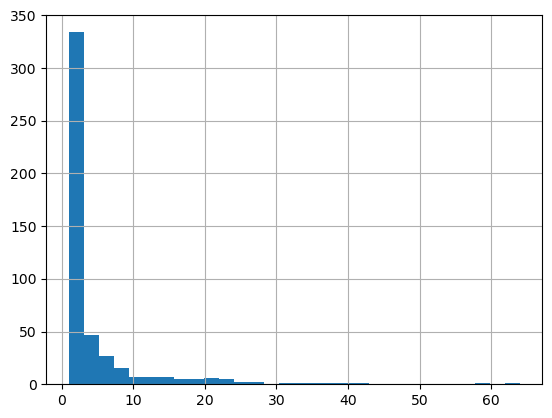

In [31]:
product_counts_df['count'].hist(bins=30)

In [32]:
df_filtered = df_filtered.merge(product_counts_df, how='left', left_on='product_name', right_on='product_name')

## Proteins with interesting products

In [33]:
df_filtered[df_filtered['count']==1]

,Uniprot ID,Name,Amino acid sequence,Species,"Kingdom (plant, fungi, bacteria)","Type (mono, sesq, di, …)",Class (I or II),Substrate (including stereochemistry),Substrate ChEBI ID,Cofactors,...,SMILES of product (including stereochemistry),Product ChEBI ID,Cyclase,Fragment,Experimentally characterized,Reaction,Notes,Publication,product_name,count
1,XsTC-1,NaN,MSEKNVVRIPMKWGRIEREILTQNTIPELVDTNRLISWVKECNLAD...,Xenia sp.,Coral,di,NaN,"(2E,6E,10E)-GGPP",58756,NaN,...,[C@@]12(C(CCC=C(CC[C@@]1([C@](C2)(CCC=C(C)C)C)...,192741,yes,NaN,yes,NaN,highly expressed,https://www.nature.com/articles/s41589-022-010...,xeniaphyllene,1
8,WP_092528762.1,Diterpene synthase,MSTVQSTAAIPAAYTPGSTFYLPEFPYLLPARRHPASDRIRRSCET...,Amycolatopis arida,Bacteria,di,Class I,"(2E,6E,10E)-GGPP",58756,Mg2+,...,C/C1=C\CCC/C(C)=C/CC/C(C)=C/C[C@@H](C(C)=C)CC1,to be added,yes,NaN,yes,NaN,NaN,https://chemrxiv.org/engage/chemrxiv/article-d...,"(Z)-eunicellane benditerpe-2,6,15-triene",1
9,WP_092528762.1,Diterpene synthase,MSTVQSTAAIPAAYTPGSTFYLPEFPYLLPARRHPASDRIRRSCET...,Amycolatopis arida,Bacteria,di,Class I,"(2E,6E,10E)-GGPP",58756,Mg2+,...,C/C/1=C\CC/C(=C/CC(CC/C(=C/CC1)/C)C(=C)C)/C,to be added,NaN,NaN,yes,NaN,NaN,https://chemrxiv.org/engage/chemrxiv/article-d...,(R)-(–)-cembrene A,1
10,WP_089795910.1,NaN,MKTMTNEEFYAGLLDLPKPKYPFPDTIHPDFQRLREEYYNWIDTEY...,Chryseobacterium wanjuense,Bacteria,di,NaN,"(2E,6E,10E)-GGPP",58756,NaN,...,C1=2CC[C@@H]([C@@]13[C@@]([C@@H](CCC2C)C(C)C)(...,192983,yes,NaN,yes,NaN,NaN,https://onlinelibrary.wiley.com/doi/full/10.10...,ent-bonnadiene,1
11,WP_089795910.1,NaN,MKTMTNEEFYAGLLDLPKPKYPFPDTIHPDFQRLREEYYNWIDTEY...,Chryseobacterium wanjuense,Bacteria,di,NaN,"(2E,6E,10E)-GGPP",58756,NaN,...,C1C[C@@H](C=2[C@@]13[C@](C=C(CC2)C)([C@@H](CC[...,192984,yes,NaN,yes,NaN,NaN,https://onlinelibrary.wiley.com/doi/full/10.10...,wanjudiene,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,A0A125SXN2,Alpha-onocerin synthase LCD,MWRLRTGSSTVDKADSWLSSLNNHLGRQIWCYDPEAGTPQEREAVE...,Lycopodium clavatum,Plantae,tri,NaN,pre-α-onocerin,138305,NaN,...,C1C[C@@H](C([C@]2([C@]1([C@H](C(CC2)=C)CC[C@H]...,138303,yes,NaN,yes,NaN,NaN,https://chemistry-europe.onlinelibrary.wiley.c...,α-onocerin,1
2012,A0A125SXN1,Pre-alpha-onocerin synthase LCC,MWKLKIAEGSPGLDTLNDHVGRQIWCYEKDAGTPEEHAEVEEARAK...,Lycopodium clavatum,Plantae,tri,NaN,"(3S,22S)-2,3:22,23-diepoxy-2,3,22,23-tetrahydr...",138307,NaN,...,C1C[C@@H](C([C@]2([C@]1([C@H](C(CC2)=C)CC/C=C(...,138305,yes,NaN,yes,NaN,NaN,https://chemistry-europe.onlinelibrary.wiley.c...,pre-α-onocerin,1
2029,A0A0P0ZEM1,Stellatatriene synthase,MEYKFSTVVDPGTYETHGLCEGYEVRYHKNAELEDIGCLRCQEHWR...,Emericella variicolor,Fungi,sester,NaN,"(2E,6E,10E,14E)-GFPP",57907,NaN,...,[H][C@]12CC[C@]3(C)C\C=C(C)\CC\C=C(C)\CC[C@@]3...,138048,yes,NaN,yes,NaN,"also synthetizes (2E,6E,10E,14E)-GFPP",https://pubs.acs.org/doi/10.1021/acs.orglett.5...,"stellata-2,6,19-triene",1
2043,A0A0F4GLU2,Geranylgeranyl diphosphate synthase,MAEFAIPVPDDVVKQSGTLSRFPTAVHREHARCLAAANKIRDDFAA...,Zymoseptoria brevis,Fungi,sester,NaN,"(2E,6E,10E,14E)-GFPP",57907,NaN,...,[H][C@@]12C\C=C(C)/[C@@]3([H])C[C@@]4(C)CC[C@H...,177887,yes,NaN,yes,NaN,NaN,https://www.pnas.org/content/118/29/e2023247118,sesterevisene,1


In [34]:
df_filtered[df_filtered['count']==1]['Uniprot ID'].nunique()

164

In [35]:
df_filtered[df_filtered['count']==2]['Uniprot ID'].nunique()

148

## Export

In [36]:
cols = ['Uniprot ID', 'Name', 'Species','Kingdom (plant, fungi, bacteria)', 'Type (mono, sesq, di, …)','product_name', 'count', 'Notes']

In [37]:
df_filtered_unique = df_filtered.groupby('Uniprot ID')[['Name','Species','Kingdom (plant, fungi, bacteria)']].first()

In [38]:
df_filtered_unique

,Name,Species,"Kingdom (plant, fungi, bacteria)"
Uniprot ID,,,
A0A023J8Z5,Delta guaiene synthase,Aquilaria microcarpa,Plantae
A0A059PYD5,Caryophyllene synthase,Artemisia annua,Plantae
A0A067SEC9,Sesquiterpene synthase GALMADRAFT_104215,Galerina marginata,Fungi
A0A075FA51,"(+)-copalyl diphosphate synthase 3, chloroplastic",Marrubium vulgare,Plantae
A0A075FAK4,Peregrinol diphosphate synthase CPS1,Marrubium vulgare,Plantae
...,...,...,...
X4ZWN5,Diterpene synthase TPS2,Plectranthus barbatus (C. forskohlii),Plantae
X5A2Z7,Diterpene synthase TPS3,Plectranthus barbatus (C. forskohlii),Plantae
X5A4D6,Diterpene synthase TPS1,Plectranthus barbatus (C. forskohlii),Plantae


In [39]:
df_filtered_unique = df_filtered_unique.merge(df_filtered.groupby('Uniprot ID')[['product_name']].agg("; ".join), how='left', left_index=True, right_index=True)

In [40]:
df_filtered_unique

,Name,Species,"Kingdom (plant, fungi, bacteria)",product_name
Uniprot ID,,,,
A0A023J8Z5,Delta guaiene synthase,Aquilaria microcarpa,Plantae,δ-guaiene; germacrene A; α-humulene
A0A059PYD5,Caryophyllene synthase,Artemisia annua,Plantae,β-phellandrene
A0A067SEC9,Sesquiterpene synthase GALMADRAFT_104215,Galerina marginata,Fungi,β-gurjunene
A0A075FA51,"(+)-copalyl diphosphate synthase 3, chloroplastic",Marrubium vulgare,Plantae,"5α,9α,10β-labda-8(20),13-dien-15-yl diphosphat..."
A0A075FAK4,Peregrinol diphosphate synthase CPS1,Marrubium vulgare,Plantae,peregrinol diphosphate(3−)
...,...,...,...,...
X4ZWN5,Diterpene synthase TPS2,Plectranthus barbatus (C. forskohlii),Plantae,copal-8-ol diphosphate(3−)
X5A2Z7,Diterpene synthase TPS3,Plectranthus barbatus (C. forskohlii),Plantae,(13R)-Manoyl oxide
X5A4D6,Diterpene synthase TPS1,Plectranthus barbatus (C. forskohlii),Plantae,(+)-copalyl diphosphate


In [41]:
df_filtered_unique = df_filtered_unique.merge(pd.DataFrame(df_filtered.groupby('Uniprot ID')['Type (mono, sesq, di, …)'].unique().agg("; ".join)), how='left', left_index=True, right_index=True)

C:\Users\terca\AppData\Local\Temp\ipykernel_11252\1714231479.py:1: FutureWarning: using <built-in method join of str object at 0x0000017AE83BB730> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  df_filtered_unique = df_filtered_unique.merge(pd.DataFrame(df_filtered.groupby('Uniprot ID')['Type (mono, sesq, di, …)'].unique().agg("; ".join)), how='left', left_index=True, right_index=True)


In [42]:
df_filtered_unique = df_filtered_unique.merge(df_filtered.groupby('Uniprot ID')[['count']].agg(list), how='left', left_index=True, right_index=True)

In [43]:
df_filtered_unique

,Name,Species,"Kingdom (plant, fungi, bacteria)",product_name,"Type (mono, sesq, di, …)",count
Uniprot ID,,,,,,
A0A023J8Z5,Delta guaiene synthase,Aquilaria microcarpa,Plantae,δ-guaiene; germacrene A; α-humulene,sesq,"[8, 6, 2]"
A0A059PYD5,Caryophyllene synthase,Artemisia annua,Plantae,β-phellandrene,mono,[13]
A0A067SEC9,Sesquiterpene synthase GALMADRAFT_104215,Galerina marginata,Fungi,β-gurjunene,sesq,[1]
A0A075FA51,"(+)-copalyl diphosphate synthase 3, chloroplastic",Marrubium vulgare,Plantae,"5α,9α,10β-labda-8(20),13-dien-15-yl diphosphat...",di-int,[16]
A0A075FAK4,Peregrinol diphosphate synthase CPS1,Marrubium vulgare,Plantae,peregrinol diphosphate(3−),di-int,[2]
...,...,...,...,...,...,...
X4ZWN5,Diterpene synthase TPS2,Plectranthus barbatus (C. forskohlii),Plantae,copal-8-ol diphosphate(3−),di-int,[8]
X5A2Z7,Diterpene synthase TPS3,Plectranthus barbatus (C. forskohlii),Plantae,(13R)-Manoyl oxide,di,[3]
X5A4D6,Diterpene synthase TPS1,Plectranthus barbatus (C. forskohlii),Plantae,(+)-copalyl diphosphate,di-int,[6]


In [44]:
df_filtered_unique.columns = ['name', 'species', 'kingdom', 'product_names','type', 'product_counts']

In [45]:
df_filtered_unique

,name,species,kingdom,product_names,type,product_counts
Uniprot ID,,,,,,
A0A023J8Z5,Delta guaiene synthase,Aquilaria microcarpa,Plantae,δ-guaiene; germacrene A; α-humulene,sesq,"[8, 6, 2]"
A0A059PYD5,Caryophyllene synthase,Artemisia annua,Plantae,β-phellandrene,mono,[13]
A0A067SEC9,Sesquiterpene synthase GALMADRAFT_104215,Galerina marginata,Fungi,β-gurjunene,sesq,[1]
A0A075FA51,"(+)-copalyl diphosphate synthase 3, chloroplastic",Marrubium vulgare,Plantae,"5α,9α,10β-labda-8(20),13-dien-15-yl diphosphat...",di-int,[16]
A0A075FAK4,Peregrinol diphosphate synthase CPS1,Marrubium vulgare,Plantae,peregrinol diphosphate(3−),di-int,[2]
...,...,...,...,...,...,...
X4ZWN5,Diterpene synthase TPS2,Plectranthus barbatus (C. forskohlii),Plantae,copal-8-ol diphosphate(3−),di-int,[8]
X5A2Z7,Diterpene synthase TPS3,Plectranthus barbatus (C. forskohlii),Plantae,(13R)-Manoyl oxide,di,[3]
X5A4D6,Diterpene synthase TPS1,Plectranthus barbatus (C. forskohlii),Plantae,(+)-copalyl diphosphate,di-int,[6]


In [46]:
df_filtered_unique = df_filtered_unique.merge(df_filtered.loc[df_filtered.groupby('Uniprot ID')['count'].idxmin(),['Uniprot ID','product_name','count']], how='left', left_index=True, right_on='Uniprot ID')


In [47]:
df_filtered_unique.columns

Index(['name', 'species', 'kingdom', 'product_names', 'type', 'product_counts',
       'Uniprot ID', 'product_name', 'count'],
      dtype='object')

In [48]:
def get_type_general(x):
    types = x.split(';')
    types = list({t.split('-')[0] for t in types})
    if len(types) > 1:
        return 'mixed'
    else:
        return types[0]
    

In [49]:
df_filtered_unique['type_general'] =  df_filtered_unique['type'].apply(lambda x: get_type_general(x))

In [50]:
df_filtered_unique = df_filtered_unique[['Uniprot ID', 'name', 'type', 'type_general', 'species', 'kingdom', 'product_names', 'product_counts', 'product_name', 'count']]

In [51]:
df_filtered_unique['type_general'].value_counts()

type_general
sesq             475
mono             192
di               171
tri              143
mixed             86
sester            44
tetra             13
hemi               4
hsqs               2
meroterpenoid      1
sesquar            1
Name: count, dtype: int64

In [52]:
df_filtered_unique = df_filtered_unique.rename(columns={"Uniprot ID": "id", "product_name": "most_unique_product_name", "count": "most_unique_product_count"})

In [53]:
def change_kingdom(x):
    if ('Animalia' in x) or ('Human' in x):
        return 'Animalia'
    return x

In [54]:
df_filtered_unique['kingdom'] = df_filtered_unique['kingdom'].apply(lambda x: change_kingdom(x))

In [55]:
df_filtered_unique.to_csv('tps_db_filtered_products.tsv', sep='\t', index=False)